# Portfolio NAV Visualization

Quick visualization notebook for comparing portfolio NAV vs SPY benchmark from backtest results.

**Usage:**
1. Update the `backtest_dir` variable below with your backtest results directory
2. Run all cells to generate visualizations

In [36]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Setup complete!")

✓ Setup complete!


## Load Backtest Results

Update the path below to point to your backtest results directory.

In [37]:
# UPDATE THIS PATH to your backtest results
backtest_dir = Path('../artifacts/backtests/20260201_023759_momentum_acceleration_long_lookback_days126_min_periods100_short_lookback_days63_top7_tier3_monthly')

# Verify directory exists
if not backtest_dir.exists():
    print(f"❌ Error: Directory not found: {backtest_dir}")
    print("\nAvailable backtests:")
    for d in sorted(Path('../artifacts/backtests').glob('*'), reverse=True)[:5]:
        print(f"  - {d.name}")
else:
    print(f"✓ Loading from: {backtest_dir.name}")

✓ Loading from: 20260201_023759_momentum_acceleration_long_lookback_days126_min_periods100_short_lookback_days63_top7_tier3_monthly


In [38]:
# Load equity curve
equity_file = backtest_dir / 'equity_curve.csv'
equity_df = pd.read_csv(equity_file, index_col=0, parse_dates=True)

# Load metrics
metrics_file = backtest_dir / 'metrics.json'
with open(metrics_file) as f:
    metrics = json.load(f)

print(f"✓ Loaded {len(equity_df)} days of data")
print(f"  Period: {equity_df.index[0].date()} to {equity_df.index[-1].date()}")
print(f"\nColumns available: {list(equity_df.columns)}")

# Load SPY benchmark data and calculate buy & hold performance
print("\n✓ Loading SPY benchmark data...")
snapshot_dir = Path('../data/snapshots/snapshot_latest')
prices_df = pd.read_parquet(snapshot_dir / 'data.parquet')

# Check structure and extract SPY close prices
if isinstance(prices_df.columns, pd.MultiIndex):
    # MultiIndex columns - likely (Ticker, Price Type) format
    spy_prices = prices_df[('SPY', 'Close')]
else:
    # Simple columns
    spy_prices = prices_df['SPY']

# Align SPY to backtest dates and calculate NAV
spy_aligned = spy_prices.reindex(equity_df.index, method='ffill')
initial_capital = equity_df['nav'].iloc[0]
initial_spy_price = spy_aligned.iloc[0]
spy_shares = initial_capital / initial_spy_price

# Calculate SPY NAV (buy and hold)
equity_df['spy_nav'] = spy_shares * spy_aligned

print(f"  SPY benchmark calculated: ${equity_df['spy_nav'].iloc[0]:,.2f} → ${equity_df['spy_nav'].iloc[-1]:,.2f}")

✓ Loaded 120 days of data
  Period: 2016-01-29 to 2025-12-31

Columns available: ['nav', 'cost', 'returns']

✓ Loading SPY benchmark data...
  SPY benchmark calculated: $100,000.00 → $415,335.85


## Performance Summary

In [39]:
# Display key metrics
print("=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)
print(f"Initial Capital:    ${metrics.get('initial_capital', 100000):>12,.2f}")
print(f"Final NAV:          ${metrics.get('final_nav', 0):>12,.2f}")
print(f"Total Return:       {metrics.get('total_return', 0)*100:>12.2f}%")
print(f"Sharpe Ratio:       {metrics.get('sharpe_ratio', 0):>12.2f}")
print(f"Max Drawdown:       {metrics.get('max_drawdown', 0)*100:>12.2f}%")
print(f"Total Costs:        ${metrics.get('total_costs', 0):>12,.2f}")
print(f"Num Rebalances:     {metrics.get('num_rebalances', 0):>12}")
print("=" * 60)

PERFORMANCE SUMMARY
Initial Capital:    $  100,000.00
Final NAV:          $  146,603.17
Total Return:              46.60%
Sharpe Ratio:               0.35
Max Drawdown:             -31.86%
Total Costs:        $    7,332.11
Num Rebalances:              120


## NAV Comparison: Portfolio vs SPY Benchmark

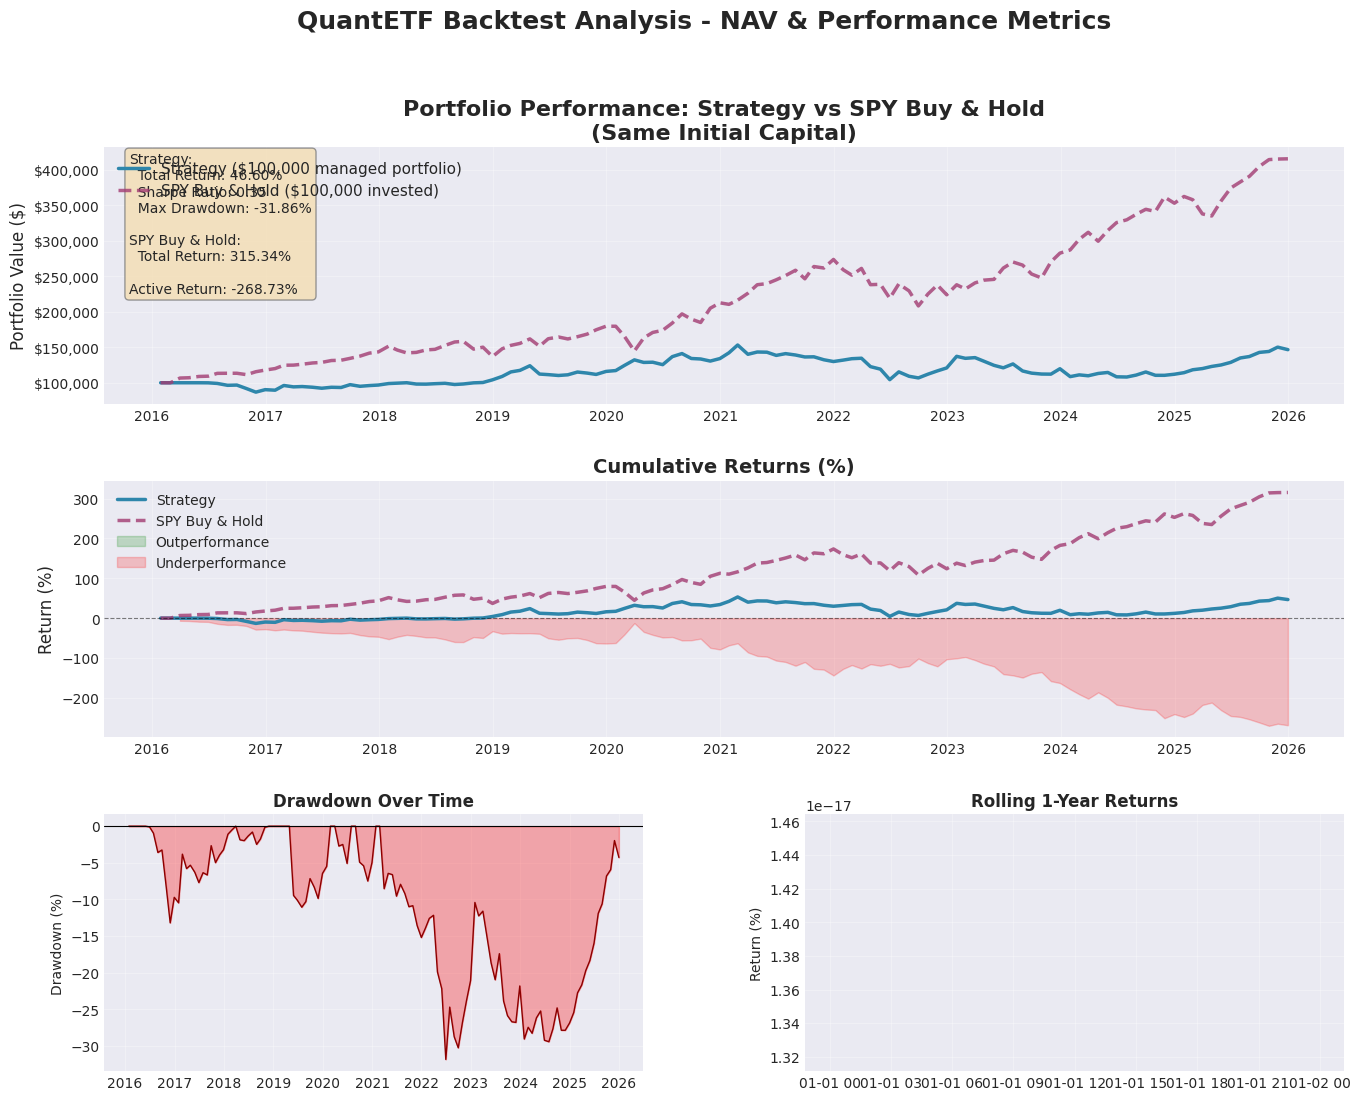


✓ Visualization complete!


In [40]:
# Create comprehensive NAV visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Main NAV chart - Strategy vs SPY Buy & Hold
ax1 = fig.add_subplot(gs[0, :])

# Get initial capital
initial_capital = equity_df['nav'].iloc[0]

# Plot Strategy
ax1.plot(equity_df.index, equity_df['nav'], 
         label=f'Strategy (${initial_capital:,.0f} managed portfolio)', 
         linewidth=2.5, color='#2E86AB')

# Plot SPY Buy & Hold
if 'spy_nav' in equity_df.columns:
    ax1.plot(equity_df.index, equity_df['spy_nav'], 
             label=f'SPY Buy & Hold (${initial_capital:,.0f} invested)', 
             linewidth=2.5, color='#A23B72', alpha=0.8, linestyle='--')

ax1.set_title('Portfolio Performance: Strategy vs SPY Buy & Hold\n(Same Initial Capital)', 
              fontsize=16, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Add metrics box with comparison
total_return = metrics.get('total_return', 0) * 100
sharpe = metrics.get('sharpe_ratio', 0)
max_dd = metrics.get('max_drawdown', 0) * 100

# Calculate SPY metrics if available
if 'spy_nav' in equity_df.columns:
    spy_total_return = (equity_df['spy_nav'].iloc[-1] / equity_df['spy_nav'].iloc[0] - 1) * 100
    active_return = total_return - spy_total_return
    
    metrics_text = f"Strategy:\n"
    metrics_text += f"  Total Return: {total_return:.2f}%\n"
    metrics_text += f"  Sharpe Ratio: {sharpe:.2f}\n"
    metrics_text += f"  Max Drawdown: {max_dd:.2f}%\n\n"
    metrics_text += f"SPY Buy & Hold:\n"
    metrics_text += f"  Total Return: {spy_total_return:.2f}%\n\n"
    metrics_text += f"Active Return: {active_return:+.2f}%"
else:
    metrics_text = f"Total Return: {total_return:.2f}%\n"
    metrics_text += f"Sharpe Ratio: {sharpe:.2f}\n"
    metrics_text += f"Max Drawdown: {max_dd:.2f}%"

ax1.text(0.02, 0.98, metrics_text,
        transform=ax1.transAxes, fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='gray'))

# 2. Cumulative Returns Comparison
ax2 = fig.add_subplot(gs[1, :])
strategy_returns = (equity_df['nav'] / equity_df['nav'].iloc[0] - 1) * 100

if 'spy_nav' in equity_df.columns:
    spy_returns = (equity_df['spy_nav'] / equity_df['spy_nav'].iloc[0] - 1) * 100
    
    ax2.plot(equity_df.index, strategy_returns, 
            label='Strategy', linewidth=2.5, color='#2E86AB')
    ax2.plot(equity_df.index, spy_returns, 
            label='SPY Buy & Hold', linewidth=2.5, color='#A23B72', alpha=0.8, linestyle='--')
    
    # Shade outperformance/underperformance
    outperformance = strategy_returns - spy_returns
    ax2.fill_between(equity_df.index, 0, outperformance, 
                     where=(outperformance >= 0), color='green', alpha=0.2, label='Outperformance')
    ax2.fill_between(equity_df.index, 0, outperformance, 
                     where=(outperformance < 0), color='red', alpha=0.2, label='Underperformance')
else:
    ax2.plot(equity_df.index, strategy_returns, 
            label='Portfolio', linewidth=2.5, color='#2E86AB')

ax2.set_title('Cumulative Returns (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Return (%)', fontsize=12)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

# 3. Drawdown Analysis
ax3 = fig.add_subplot(gs[2, 0])
running_max = equity_df['nav'].cummax()
drawdown = (equity_df['nav'] - running_max) / running_max * 100

ax3.fill_between(equity_df.index, drawdown, 0, color='red', alpha=0.3)
ax3.plot(equity_df.index, drawdown, color='darkred', linewidth=1)
ax3.set_title('Drawdown Over Time', fontsize=12, fontweight='bold')
ax3.set_ylabel('Drawdown (%)', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# 4. Rolling Returns (1-year)
ax4 = fig.add_subplot(gs[2, 1])
daily_returns = equity_df['nav'].pct_change()
rolling_returns = daily_returns.rolling(252).apply(lambda x: (1 + x).prod() - 1) * 100

ax4.plot(equity_df.index, rolling_returns, color='#2E86AB', linewidth=1.5)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax4.set_title('Rolling 1-Year Returns', fontsize=12, fontweight='bold')
ax4.set_ylabel('Return (%)', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.fill_between(equity_df.index, rolling_returns, 0, 
                 where=(rolling_returns >= 0), color='green', alpha=0.2)
ax4.fill_between(equity_df.index, rolling_returns, 0, 
                 where=(rolling_returns < 0), color='red', alpha=0.2)

plt.suptitle('QuantETF Backtest Analysis - NAV & Performance Metrics', 
             fontsize=18, fontweight='bold', y=0.995)

plt.show()

print(f"\n✓ Visualization complete!")

## Daily Returns Distribution

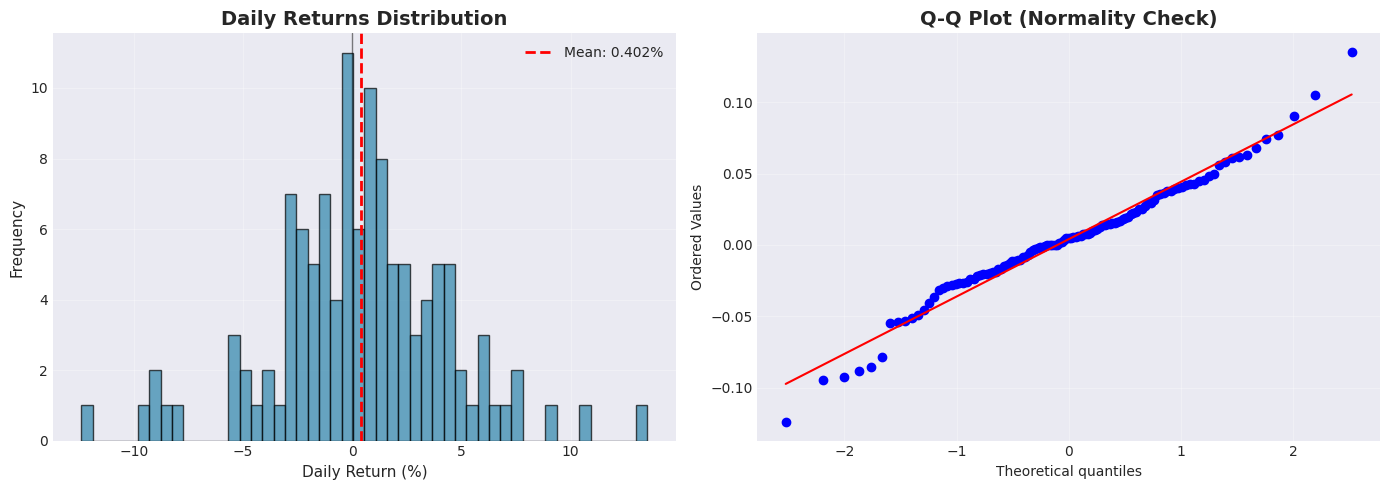


Daily Returns Statistics:
Mean:        0.402%
Std Dev:     4.018%
Skewness:   -0.124
Kurtosis:    1.425
Min:       -12.400%
Max:        13.517%


In [41]:
# Calculate daily returns
daily_returns = equity_df['nav'].pct_change().dropna()

# Create returns distribution plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(daily_returns * 100, bins=50, color='#2E86AB', alpha=0.7, edgecolor='black')
ax1.axvline(x=daily_returns.mean() * 100, color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {daily_returns.mean()*100:.3f}%')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax1.set_title('Daily Returns Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Daily Return (%)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.legend()
ax1.grid(True, alpha=0.3)

# QQ plot
from scipy import stats
stats.probplot(daily_returns, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("\nDaily Returns Statistics:")
print("=" * 40)
print(f"Mean:     {daily_returns.mean()*100:>8.3f}%")
print(f"Std Dev:  {daily_returns.std()*100:>8.3f}%")
print(f"Skewness: {daily_returns.skew():>8.3f}")
print(f"Kurtosis: {daily_returns.kurtosis():>8.3f}")
print(f"Min:      {daily_returns.min()*100:>8.3f}%")
print(f"Max:      {daily_returns.max()*100:>8.3f}%")
print("=" * 40)

## Export Visualization

Save the main chart as a high-resolution image.

✓ Saved to: ../artifacts/backtests/20260201_023759_momentum_acceleration_long_lookback_days126_min_periods100_short_lookback_days63_top7_tier3_monthly/nav_visualization.png


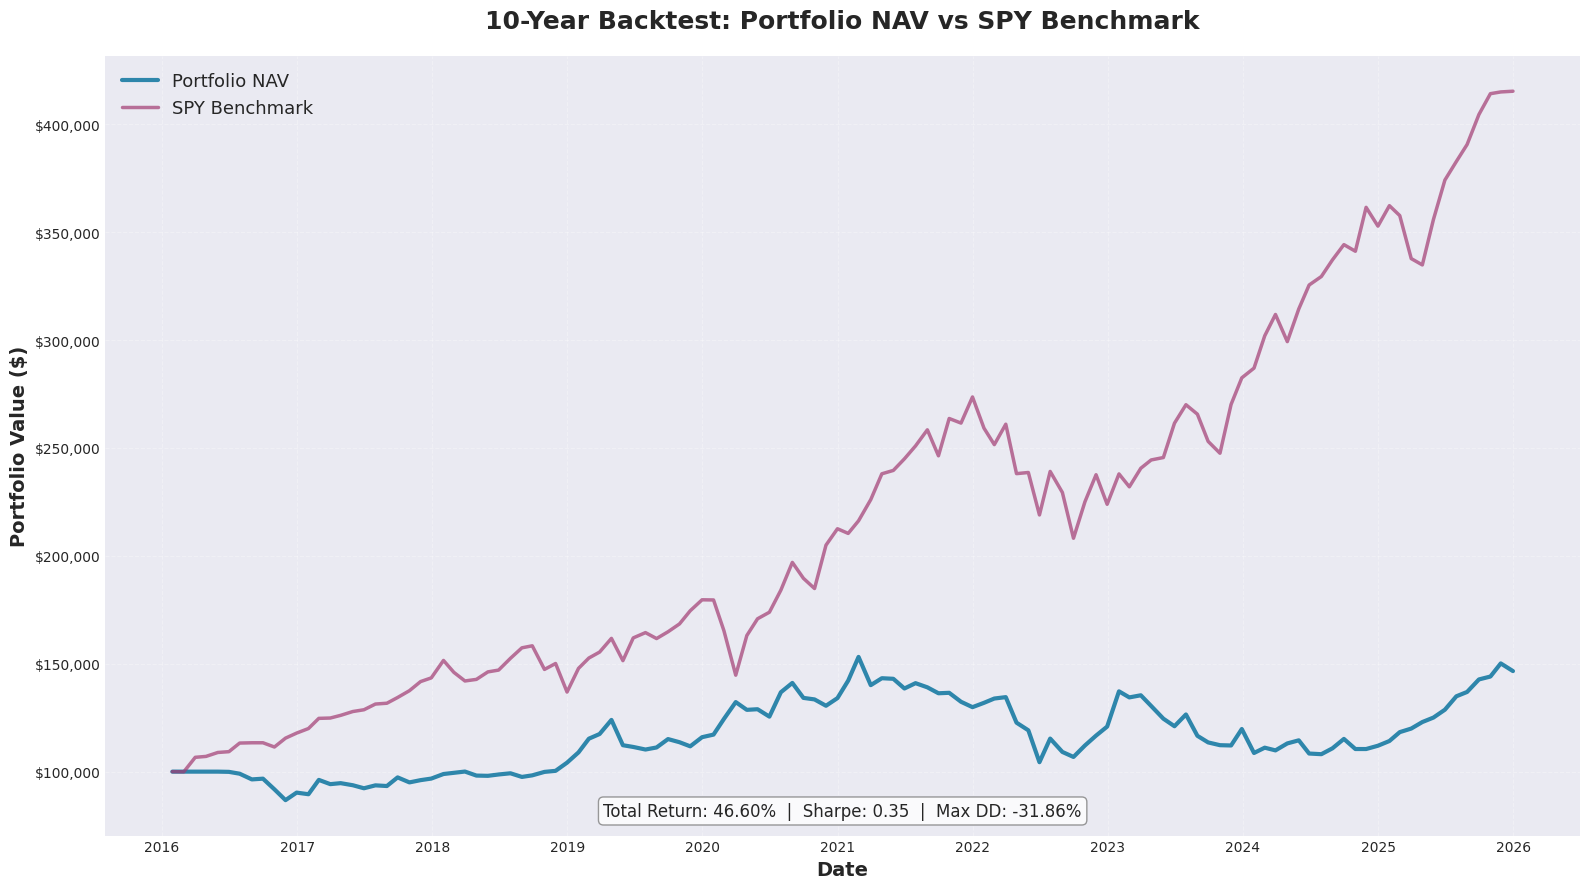

In [42]:
# Create final clean chart for export
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(equity_df.index, equity_df['nav'], 
        label='Portfolio NAV', linewidth=3, color='#2E86AB')

if 'spy_nav' in equity_df.columns:
    ax.plot(equity_df.index, equity_df['spy_nav'], 
            label='SPY Benchmark', linewidth=2.5, color='#A23B72', alpha=0.7)

ax.set_title('10-Year Backtest: Portfolio NAV vs SPY Benchmark', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Portfolio Value ($)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=13, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Add metrics annotation
metrics_text = (f"Total Return: {total_return:.2f}%  |  "
               f"Sharpe: {sharpe:.2f}  |  "
               f"Max DD: {max_dd:.2f}%")
ax.text(0.5, 0.02, metrics_text,
        transform=ax.transAxes, fontsize=12,
        ha='center', va='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

plt.tight_layout()

# Save
output_file = backtest_dir / 'nav_visualization.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved to: {output_file}")

plt.show()